In [1]:
!pip3 install lightgbm scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [7]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed) # Seed 고정

In [9]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [10]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    #df_all['bant_submit'] = (df_all['bant_submit']*4).astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), list(df_train["is_converted"])
x_val, y_val = df_test.drop(["is_converted", 'id'], axis=1), list(df_test["is_converted"])

In [11]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20,40), 
        'max_depth': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1), 
        'n_estimators': trial.suggest_int('n_estimators', 50,200), 
        'scale_pos_weight':rate,
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 80), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'objective':'binary',
        'random_state': seed,
        'type':'gpu',
        'verbose':-1,
        'n_jobs':-1,
    }
    
    score = []
    clf = LGBMClassifier(**params, feature_name='auto', categorical_feature = 'auto')
    clf.fit(x_train, y_train)
        
    y_pred = clf.predict(x_val)
    score = f1_score(y_val,y_pred,labels=[True,False])
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-12 12:24:32,700] A new study created in memory with name: no-name-38583556-f429-4bb6-af97-21c0e3c6002b
[I 2024-02-12 12:24:33,077] Trial 0 finished with value: 0.8517887563884157 and parameters: {'num_leaves': 27, 'learning_rate': 0.0951207163345817, 'n_estimators': 160, 'min_child_samples': 50, 'colsample_bytree': 0.7468055921327309, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.8517887563884157.
[I 2024-02-12 12:24:33,559] Trial 1 finished with value: 0.8751047778709137 and parameters: {'num_leaves': 38, 'learning_rate': 0.06051038616257767, 'n_estimators': 156, 'min_child_samples': 6, 'colsample_bytree': 0.9909729556485982, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 0.8751047778709137.
[I 2024-02-12 12:24:33,807] Trial 2 finished with value: 0.868380062305296 and parameters: {'num_leaves': 23, 'learning_rate': 0.01915704647548995, 'n_estimators': 95, 'min_child_sample

[I 2024-02-12 12:24:40,797] Trial 24 finished with value: 0.9347238315952106 and parameters: {'num_leaves': 24, 'learning_rate': 0.06335556886656059, 'n_estimators': 104, 'min_child_samples': 48, 'colsample_bytree': 0.8554371189596269, 'reg_alpha': 0.6642405092672782, 'reg_lambda': 3.1688081711470715}. Best is trial 24 with value: 0.9347238315952106.
[I 2024-02-12 12:24:41,103] Trial 25 finished with value: 0.936087295401403 and parameters: {'num_leaves': 25, 'learning_rate': 0.06445624992281396, 'n_estimators': 108, 'min_child_samples': 45, 'colsample_bytree': 0.8589536382418398, 'reg_alpha': 0.8735341412456021, 'reg_lambda': 1.6062511744687922}. Best is trial 25 with value: 0.936087295401403.
[I 2024-02-12 12:24:41,491] Trial 26 finished with value: 0.9171668667466987 and parameters: {'num_leaves': 28, 'learning_rate': 0.06180771532819319, 'n_estimators': 107, 'min_child_samples': 37, 'colsample_bytree': 0.9165916623813352, 'reg_alpha': 0.8701101267497598, 'reg_lambda': 0.80365510147

[I 2024-02-12 12:24:51,374] Trial 48 finished with value: 0.9280632411067193 and parameters: {'num_leaves': 20, 'learning_rate': 0.053068371913400664, 'n_estimators': 194, 'min_child_samples': 67, 'colsample_bytree': 0.9566348118130331, 'reg_alpha': 0.9485204565010271, 'reg_lambda': 2.9028967613256627}. Best is trial 33 with value: 0.9381761978361669.
[I 2024-02-12 12:24:51,954] Trial 49 finished with value: 0.852991452991453 and parameters: {'num_leaves': 34, 'learning_rate': 0.0741422406642118, 'n_estimators': 176, 'min_child_samples': 56, 'colsample_bytree': 0.8768175220967455, 'reg_alpha': 0.8593783206439032, 'reg_lambda': 4.631094489781874}. Best is trial 33 with value: 0.9381761978361669.
[I 2024-02-12 12:24:52,446] Trial 50 finished with value: 0.8991425071457738 and parameters: {'num_leaves': 23, 'learning_rate': 0.06641006245018029, 'n_estimators': 200, 'min_child_samples': 78, 'colsample_bytree': 0.800798784426576, 'reg_alpha': 0.742761864717048, 'reg_lambda': 2.2224834613347

[I 2024-02-12 12:25:03,659] Trial 72 finished with value: 0.9257367387033398 and parameters: {'num_leaves': 22, 'learning_rate': 0.041719547524916356, 'n_estimators': 189, 'min_child_samples': 8, 'colsample_bytree': 0.9581284974248931, 'reg_alpha': 0.49297434386386174, 'reg_lambda': 5.113661509796813}. Best is trial 54 with value: 0.941891378655526.
[I 2024-02-12 12:25:04,190] Trial 73 finished with value: 0.9393361312476154 and parameters: {'num_leaves': 21, 'learning_rate': 0.03595540173045441, 'n_estimators': 186, 'min_child_samples': 11, 'colsample_bytree': 0.9808085574825228, 'reg_alpha': 0.5566072437693546, 'reg_lambda': 5.876977279007647}. Best is trial 54 with value: 0.941891378655526.
[I 2024-02-12 12:25:04,700] Trial 74 finished with value: 0.9261538461538461 and parameters: {'num_leaves': 21, 'learning_rate': 0.039090495428069326, 'n_estimators': 176, 'min_child_samples': 13, 'colsample_bytree': 0.9836961748891884, 'reg_alpha': 0.5594489013175756, 'reg_lambda': 5.89076880694

[I 2024-02-12 12:25:16,707] Trial 96 finished with value: 0.9373799462159047 and parameters: {'num_leaves': 20, 'learning_rate': 0.04214635810324623, 'n_estimators': 193, 'min_child_samples': 7, 'colsample_bytree': 0.9623172499907245, 'reg_alpha': 0.4831696740221706, 'reg_lambda': 3.325818894925665}. Best is trial 86 with value: 0.9421808304229724.
[I 2024-02-12 12:25:17,207] Trial 97 finished with value: 0.9275019700551616 and parameters: {'num_leaves': 22, 'learning_rate': 0.04460206001790323, 'n_estimators': 179, 'min_child_samples': 12, 'colsample_bytree': 0.9815630666318529, 'reg_alpha': 0.6350085748818352, 'reg_lambda': 6.733441721412966}. Best is trial 86 with value: 0.9421808304229724.
[I 2024-02-12 12:25:17,634] Trial 98 finished with value: 0.9260577303281929 and parameters: {'num_leaves': 20, 'learning_rate': 0.04840410741194358, 'n_estimators': 197, 'min_child_samples': 21, 'colsample_bytree': 0.9533809155348505, 'reg_alpha': 0.5954242178018718, 'reg_lambda': 3.891253674227

[I 2024-02-12 12:25:30,659] Trial 120 finished with value: 0.8803668195081283 and parameters: {'num_leaves': 40, 'learning_rate': 0.039184481355115965, 'n_estimators': 198, 'min_child_samples': 11, 'colsample_bytree': 0.9672461442628885, 'reg_alpha': 0.5419503781004458, 'reg_lambda': 4.920517131075648}. Best is trial 103 with value: 0.9436455499417022.
[I 2024-02-12 12:25:31,261] Trial 121 finished with value: 0.9368258859784283 and parameters: {'num_leaves': 21, 'learning_rate': 0.03659468702864281, 'n_estimators': 193, 'min_child_samples': 16, 'colsample_bytree': 0.9490556883355129, 'reg_alpha': 0.6044087751096201, 'reg_lambda': 5.68085430493848}. Best is trial 103 with value: 0.9436455499417022.
[I 2024-02-12 12:25:31,694] Trial 122 finished with value: 0.932009167303285 and parameters: {'num_leaves': 21, 'learning_rate': 0.030567378192156203, 'n_estimators': 187, 'min_child_samples': 13, 'colsample_bytree': 0.9555306166710099, 'reg_alpha': 0.5794316634757006, 'reg_lambda': 5.375855

[I 2024-02-12 12:25:43,089] Trial 144 finished with value: 0.931672329180823 and parameters: {'num_leaves': 20, 'learning_rate': 0.032058566296636684, 'n_estimators': 168, 'min_child_samples': 64, 'colsample_bytree': 0.999785775312387, 'reg_alpha': 0.5689664821871326, 'reg_lambda': 4.583097922718275}. Best is trial 103 with value: 0.9436455499417022.
[I 2024-02-12 12:25:43,737] Trial 145 finished with value: 0.9100486223662885 and parameters: {'num_leaves': 21, 'learning_rate': 0.05151565655051788, 'n_estimators': 197, 'min_child_samples': 10, 'colsample_bytree': 0.9917499636549176, 'reg_alpha': 0.5488152527907502, 'reg_lambda': 5.32627425407577}. Best is trial 103 with value: 0.9436455499417022.
[I 2024-02-12 12:25:44,154] Trial 146 finished with value: 0.9374763167866617 and parameters: {'num_leaves': 20, 'learning_rate': 0.0346843802200147, 'n_estimators': 185, 'min_child_samples': 7, 'colsample_bytree': 0.9778341181712296, 'reg_alpha': 0.6226767748317278, 'reg_lambda': 3.9037768610

[I 2024-02-12 12:25:56,408] Trial 168 finished with value: 0.931924882629108 and parameters: {'num_leaves': 21, 'learning_rate': 0.039894961096879906, 'n_estimators': 200, 'min_child_samples': 43, 'colsample_bytree': 0.9989172872736145, 'reg_alpha': 0.5446105573012918, 'reg_lambda': 2.742628295231185}. Best is trial 162 with value: 0.9437596302003082.
[W 2024-02-12 12:25:56,668] Trial 169 failed with parameters: {'num_leaves': 20, 'learning_rate': 0.037614642609275946, 'n_estimators': 171, 'min_child_samples': 36, 'colsample_bytree': 0.9878602595562491, 'reg_alpha': 0.584768801820304, 'reg_lambda': 3.6562911668784484} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_655509/927002206.py", line 21, in objective
    clf.fit(x_train, y_train)


KeyboardInterrupt: 

In [12]:
best_param = study.best_params
best_param['verbose'] = -1
best_param['random_state'] = seed
best_param['objective'] = 'binary'
best_param['verbose'] = -1
best_param['scale_pos_weight'] = rate
best_param

{'num_leaves': 21,
 'learning_rate': 0.04048851618509133,
 'n_estimators': 178,
 'min_child_samples': 36,
 'colsample_bytree': 0.9926930125862642,
 'reg_alpha': 0.6719857547787622,
 'reg_lambda': 3.7410379721426708,
 'verbose': -1,
 'random_state': 42,
 'objective': 'binary',
 'scale_pos_weight': 11.073593073593074}

In [16]:
best_model = LGBMClassifier(**best_param, feature_name='auto', categorical_feature = 'auto')
best_model.fit(x_train,y_train)

LGBMClassifier(categorical_feature='auto', colsample_bytree=0.9926930125862642,
               feature_name='auto', learning_rate=0.04048851618509133,
               min_child_samples=36, n_estimators=178, num_leaves=21,
               objective='binary', random_state=42,
               reg_alpha=0.6719857547787622, reg_lambda=3.7410379721426708,
               scale_pos_weight=11.073593073593074, verbose=-1)

In [17]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [18]:
train_pred = best_model.predict_proba(df_train.drop("is_converted",axis=1))
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = np.argmax(train_pred,axis=1)
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]

get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4600    20]
 [ 1507 49653]]

정확도: 0.9726
정밀도: 0.7532
재현율: 0.9957
F1: 0.8576


In [19]:
threshold

0.04316211571780513

In [22]:
categorical_features = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [24]:
a_pred = best_model.predict_proba(x_test)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(a_pred, axis=1)
sum(pred)

1255

In [25]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [26]:
real = pd.read_csv(r'submission(0.767).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1175  597]
 [  80 3419]]

정확도: 0.8716
정밀도: 0.9363
재현율: 0.6631
F1: 0.7763


In [27]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1852

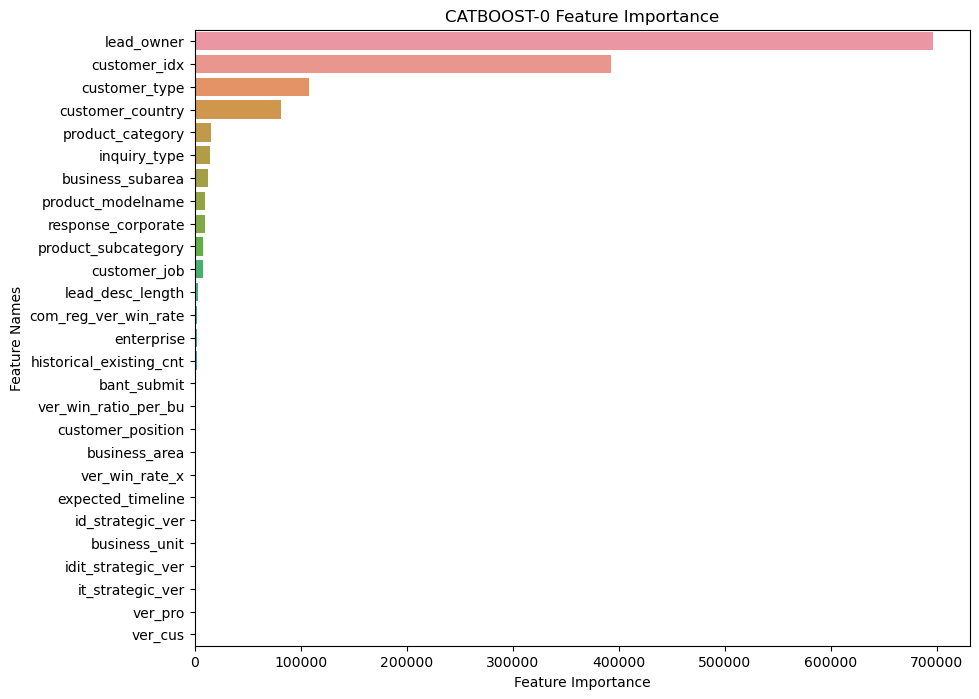

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    

    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
plot_feature_importance(best_model.booster_.feature_importance(importance_type='gain'),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')
    
    

In [ ]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_x_vals[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_vals[i], train_pred)